In [948]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fast_ml.feature_selection import get_constant_features
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Task 1

Task one will focus on combining our individual datasets, getting the combined dataset cleaned, and then preparing the data for the ensuing machine learning tasks. To this end, we will be implementing a train-test split, and then looking for potential correlations in the training set between various continuous/categorical features, and the target death_yn feature. 

In [949]:
#Combining the two datasets and saving as a new csv
df1 = pd.read_csv('covid19-cdc-22207000.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
df2 = pd.read_csv('covid19-cdc-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

combined_df = pd.concat([df1, df2])

combined_df.to_csv('covid19-cdc-combined-22207000-12468998.csv', index=False)

# Data Cleaning

To clean our data reuse some of the code we had employed earlier on in the course. We first concatenate these files in the below cell block, and run this file through our scrubber.

The product of this scrubber is <b>finalised-covid19-cdc-combined-22207000-12468998.csv</b>

In [950]:
#Reading the post-scrubbed CSV and checking length
df = pd.read_csv('finalised-covid19-cdc-combined-22207000-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

print(len(df))

35465


In [951]:
df.duplicated().sum()

6510

# Train/Test Split

With the data cleaning taken care of, we can now conduct a train text split on the data to prepare it for future machine learning tasks. Once the data is split, we can plot the train frame and investigate the relationships between the features.

In [952]:
#data for task 1
df = pd.read_csv('finalised-covid19-cdc-combined-22207000-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

#train test split on data
train, test = train_test_split(df, test_size = 0.3, random_state=42)

In [953]:
train.shape

(24825, 15)

In [954]:
test.shape

(10640, 15)

# Correlation Between Continuous Features

Correlation:  -0.007275520256231979
Weak positive correlation between these two variables.


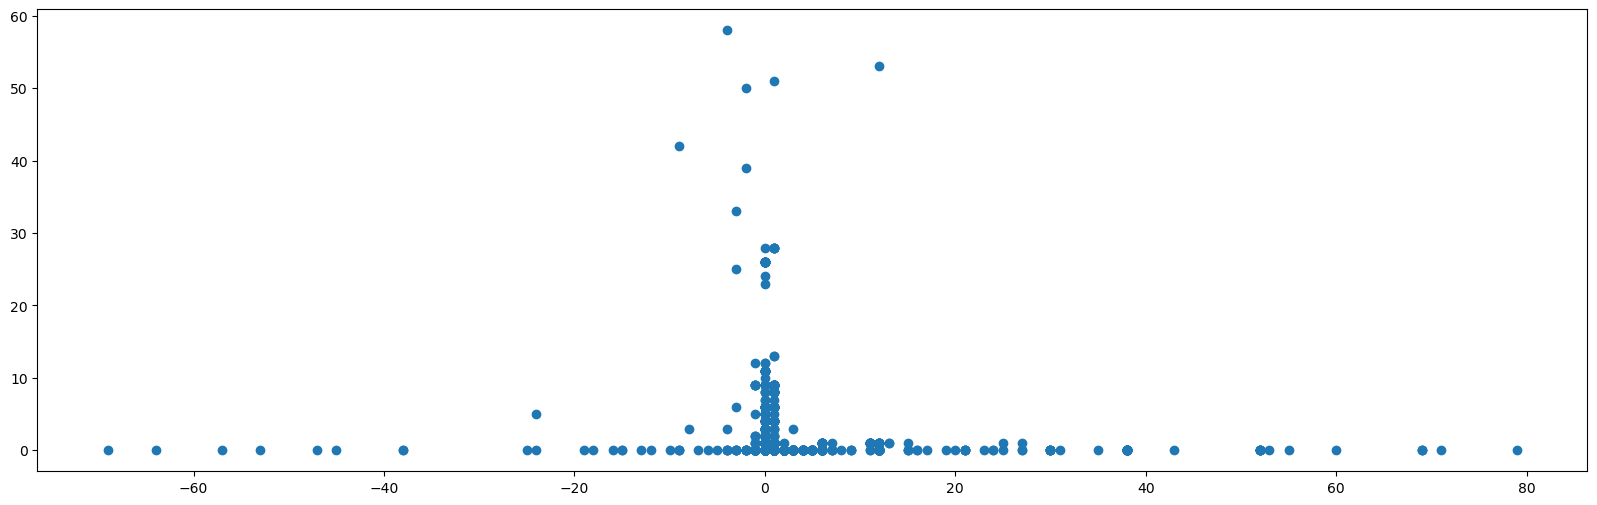

In [955]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
plt.scatter(train['case_positive_specimen_interval'], train['case_onset_interval'])
corr = train['case_onset_interval'].corr(train['case_positive_specimen_interval'])
print('Correlation: ', corr)
print('Weak positive correlation between these two variables.')
plt.show()

# Continuous Features Plotted Against Death

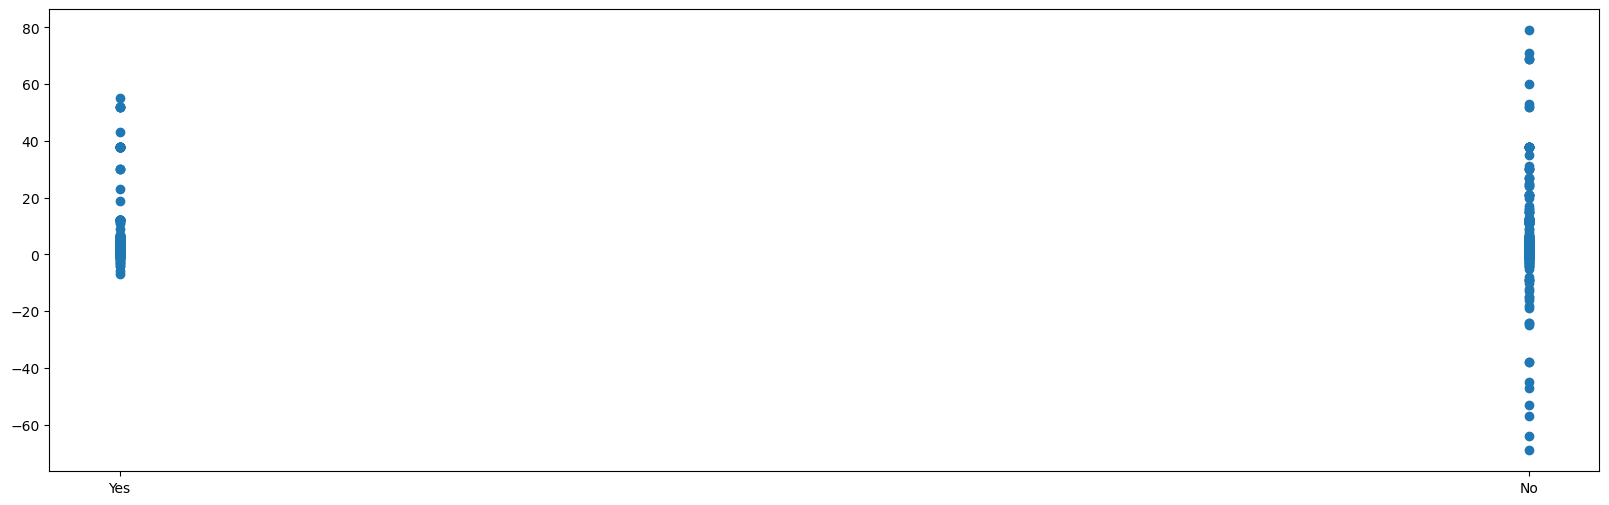

In [956]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
plt.scatter(train['death_yn'], train['case_positive_specimen_interval'])
plt.show()

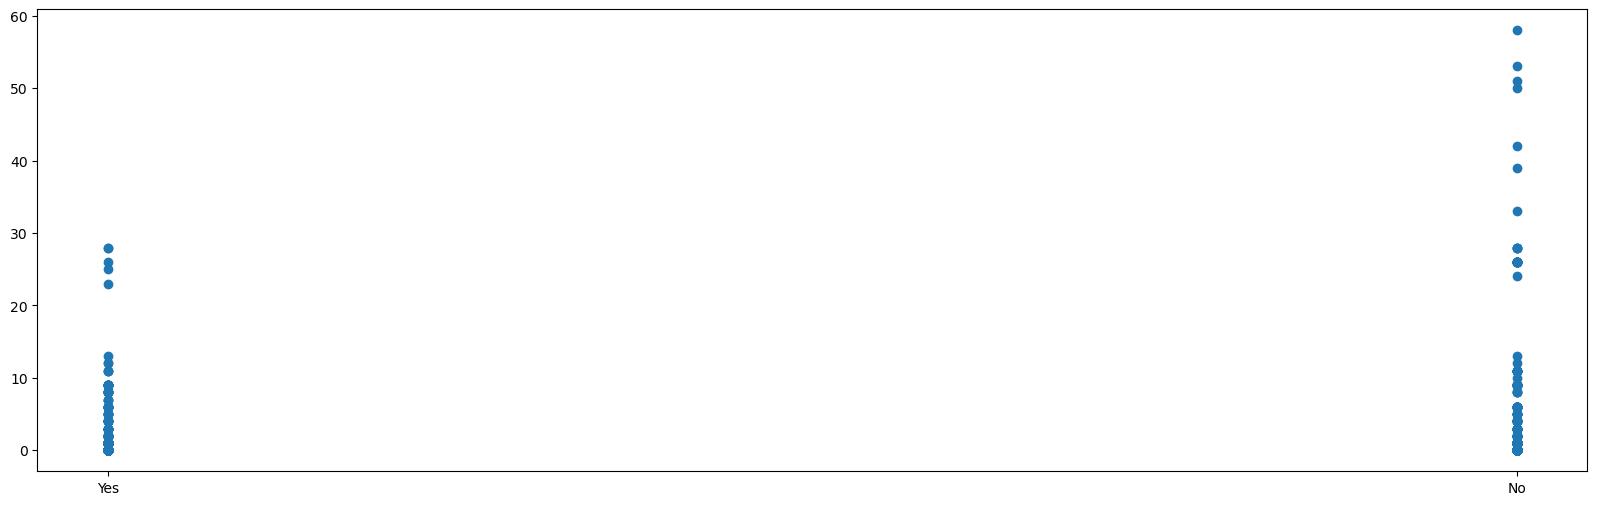

In [957]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
plt.scatter(train['death_yn'], train['case_onset_interval'])
plt.show()

# Health Related Categorical Features Plotted Against Death

Here we are looking discern patterns from our dataset by plotting deaths (yes/no) against a select number of categorical features. The features we are going to examine first are those that relate to the health profile of our patients:

1. When the patient contracted COVID.
2. What US state the patient was in when they were reported of having COVID.
3. What age group the patient belongs to.
4. Whether the patient knew if they were exposed to COVID.
5. Whether or not the patient was hospitalised or not.
6. Whether or not the patient was taken to ICU.
7. And whether or not the patient exhibited underlying conditions which could exacerbate COVID.

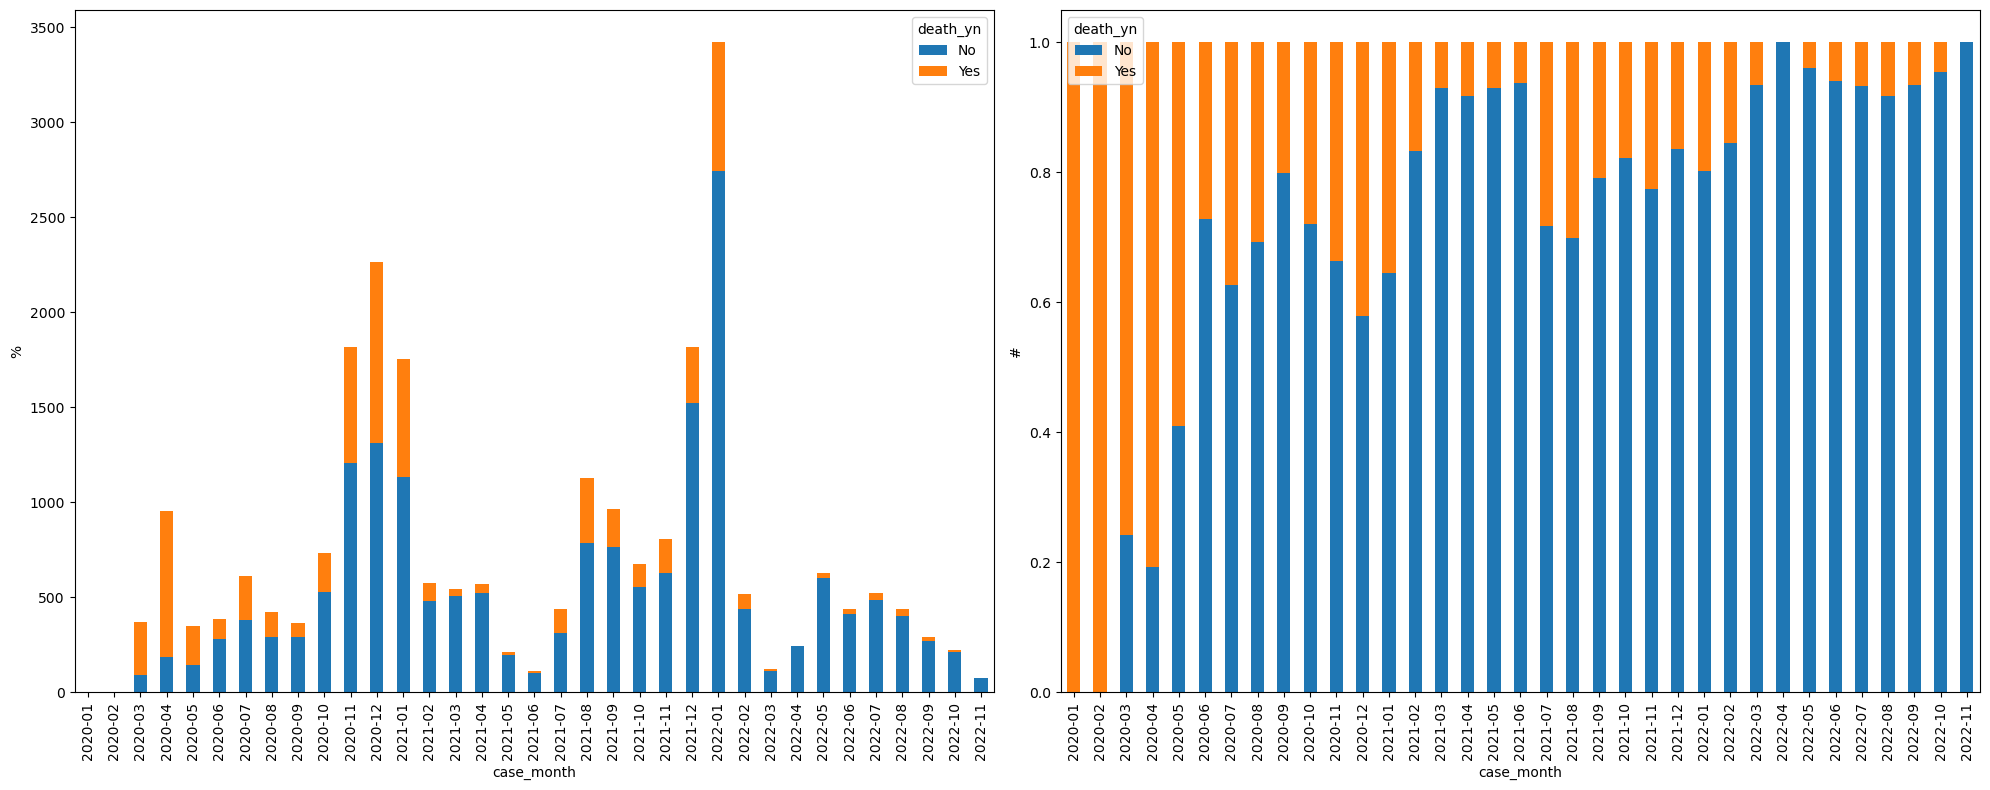

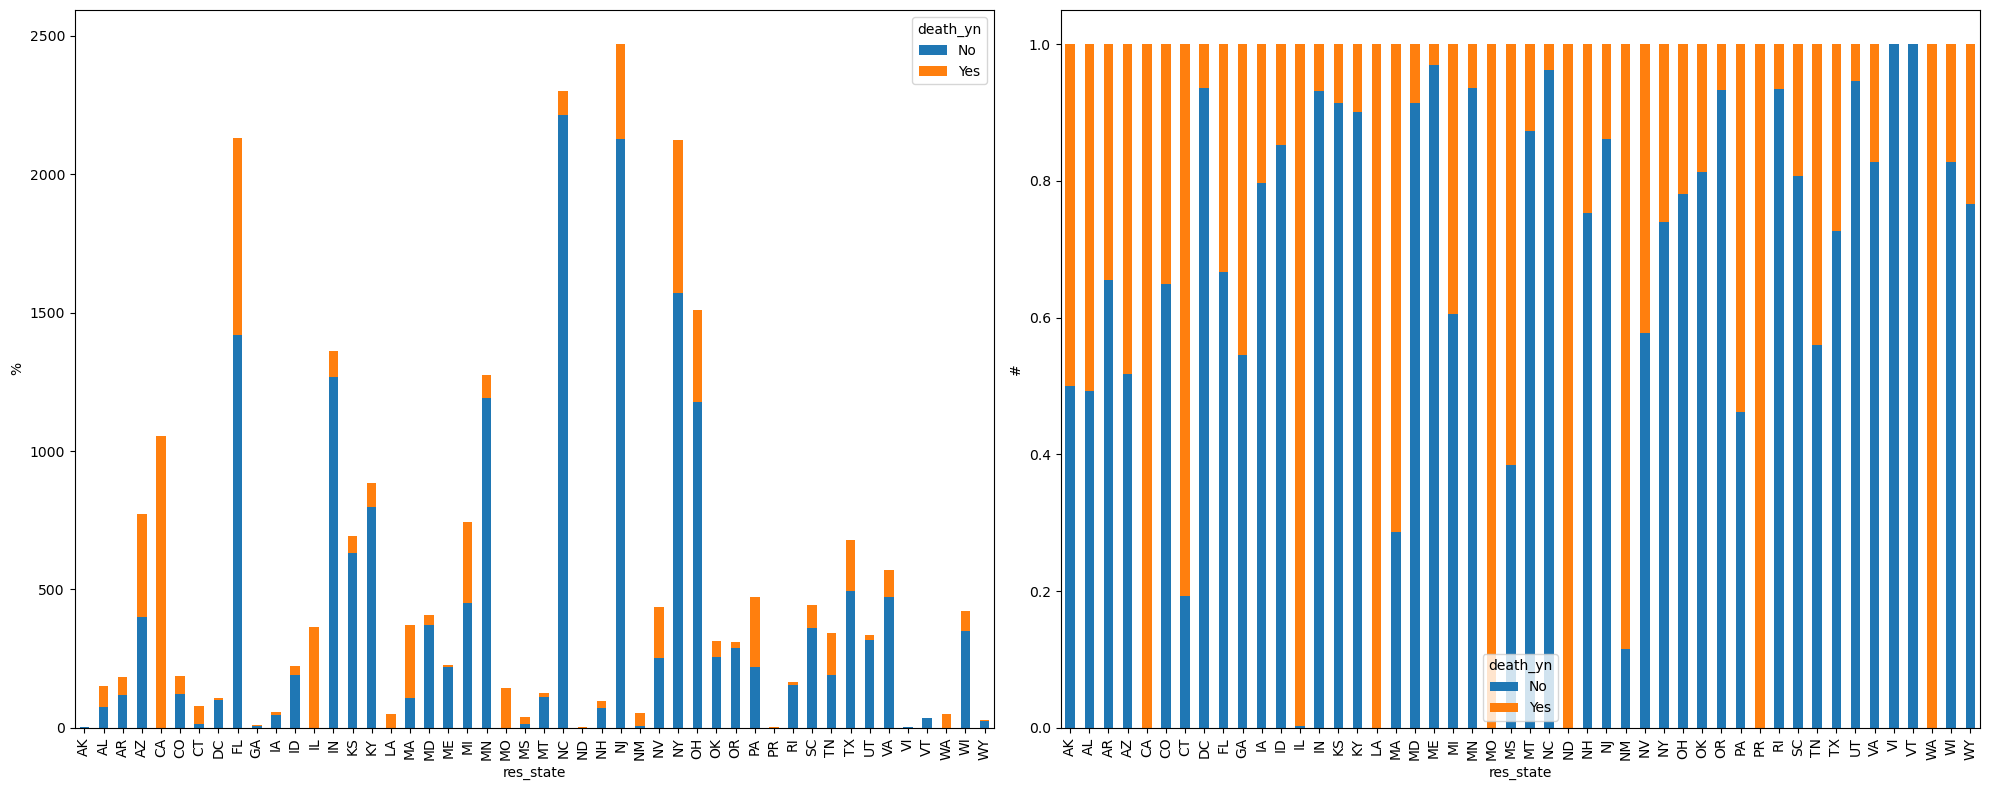

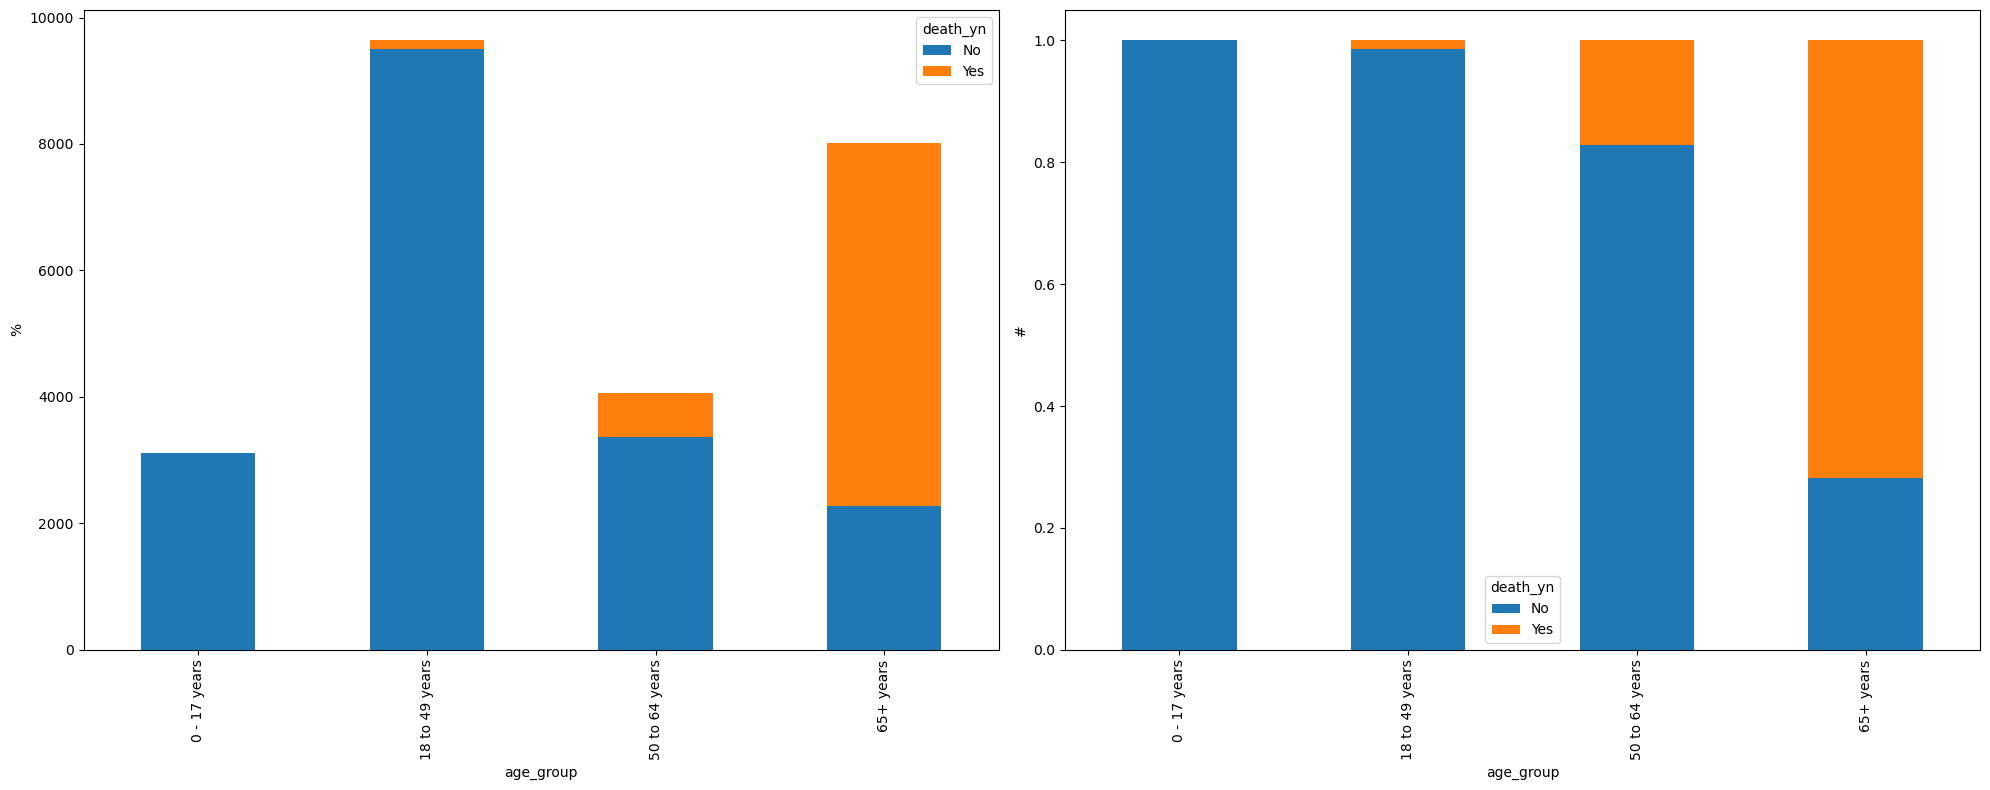

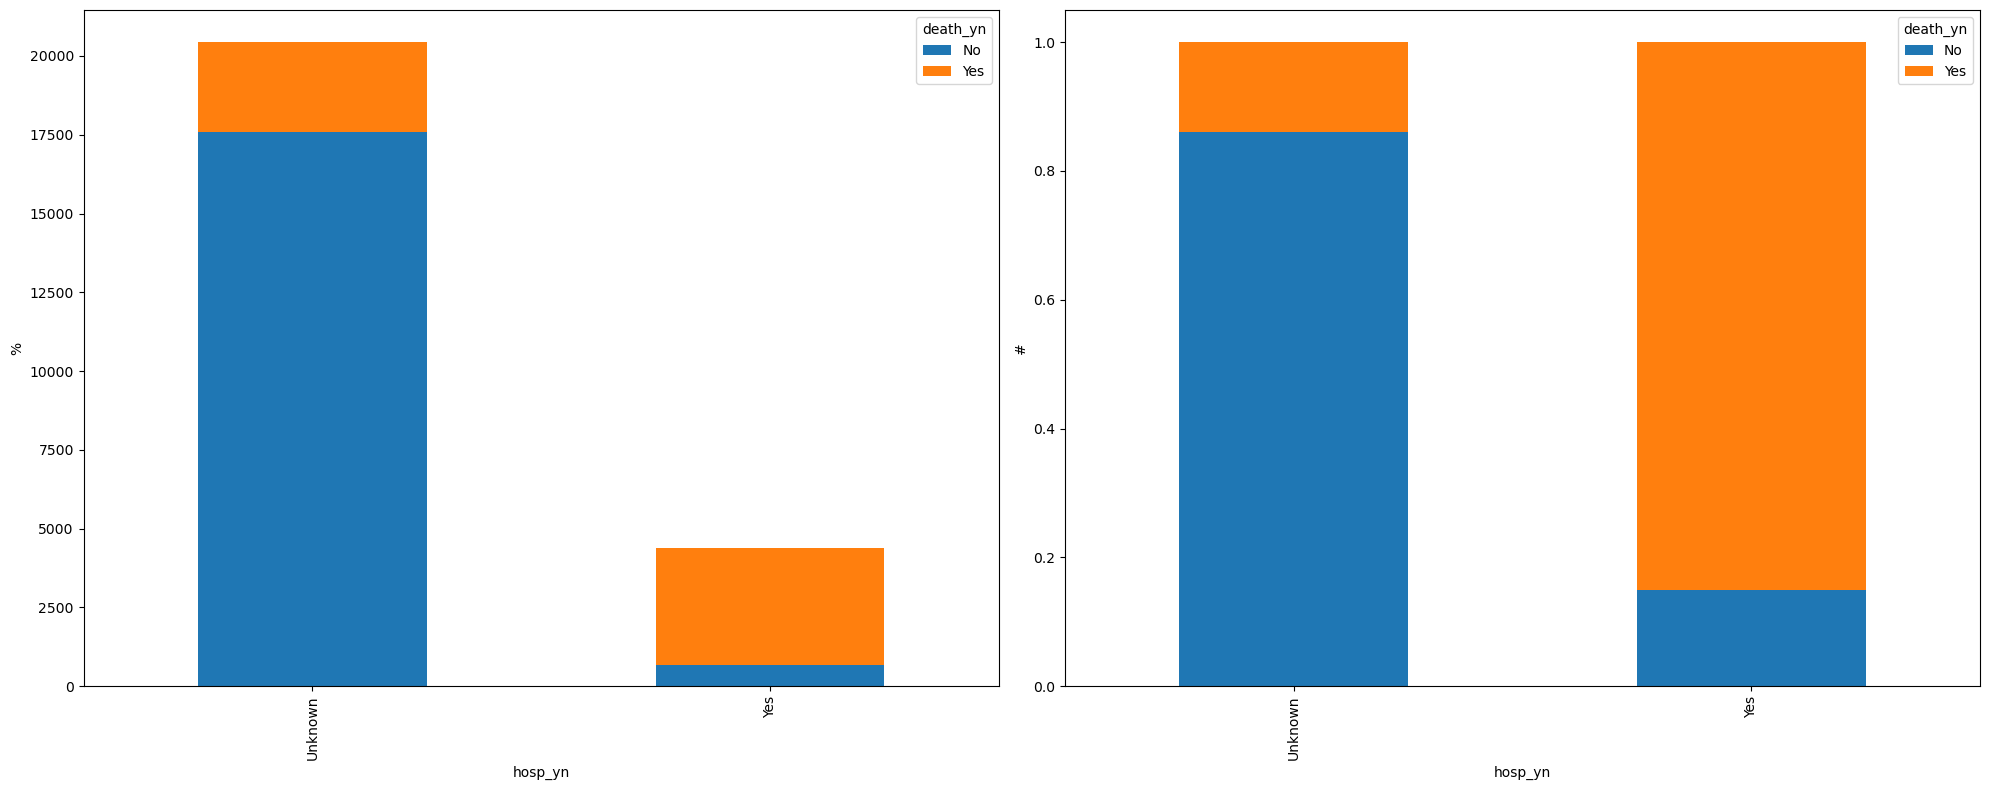

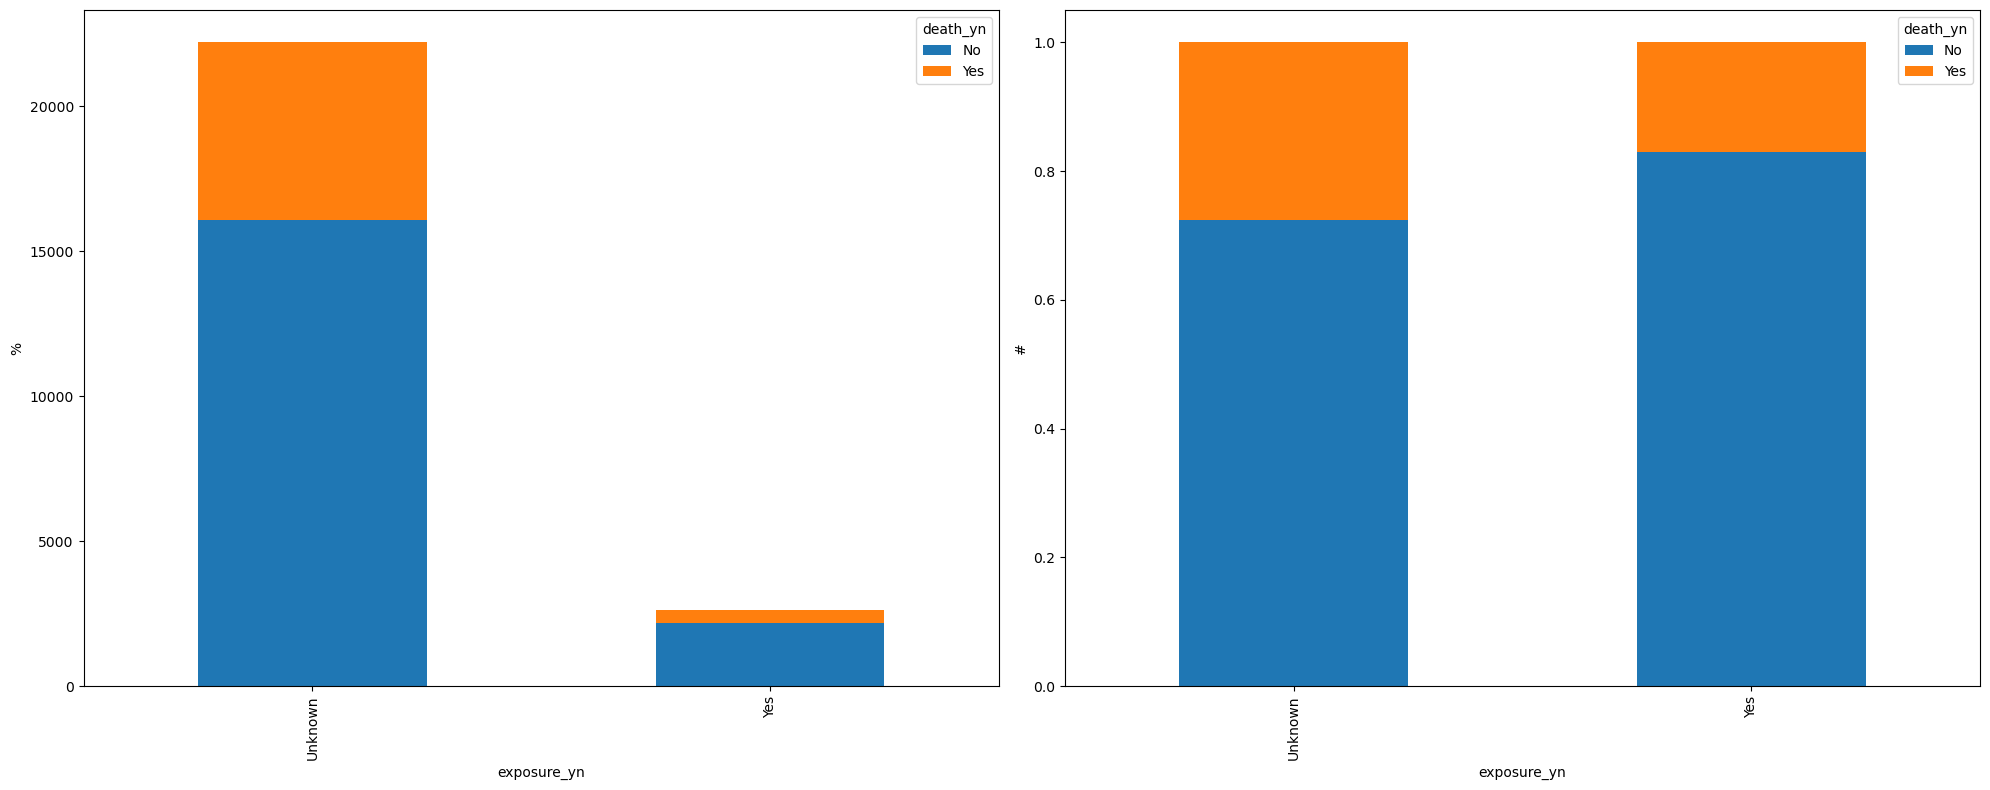

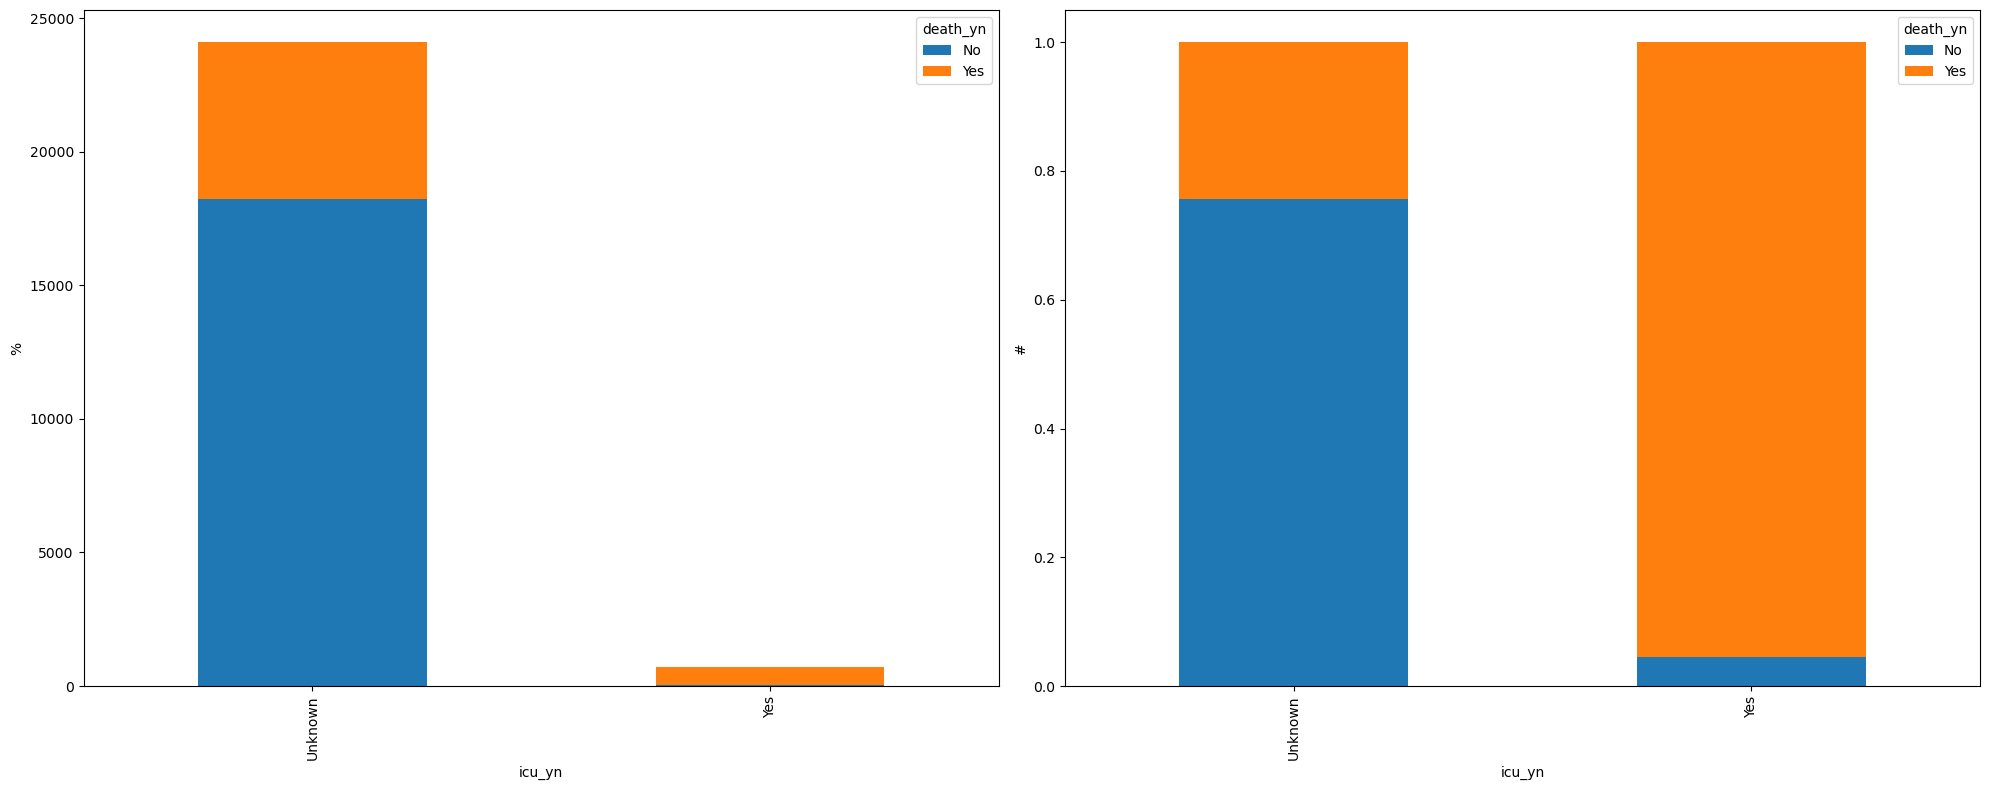

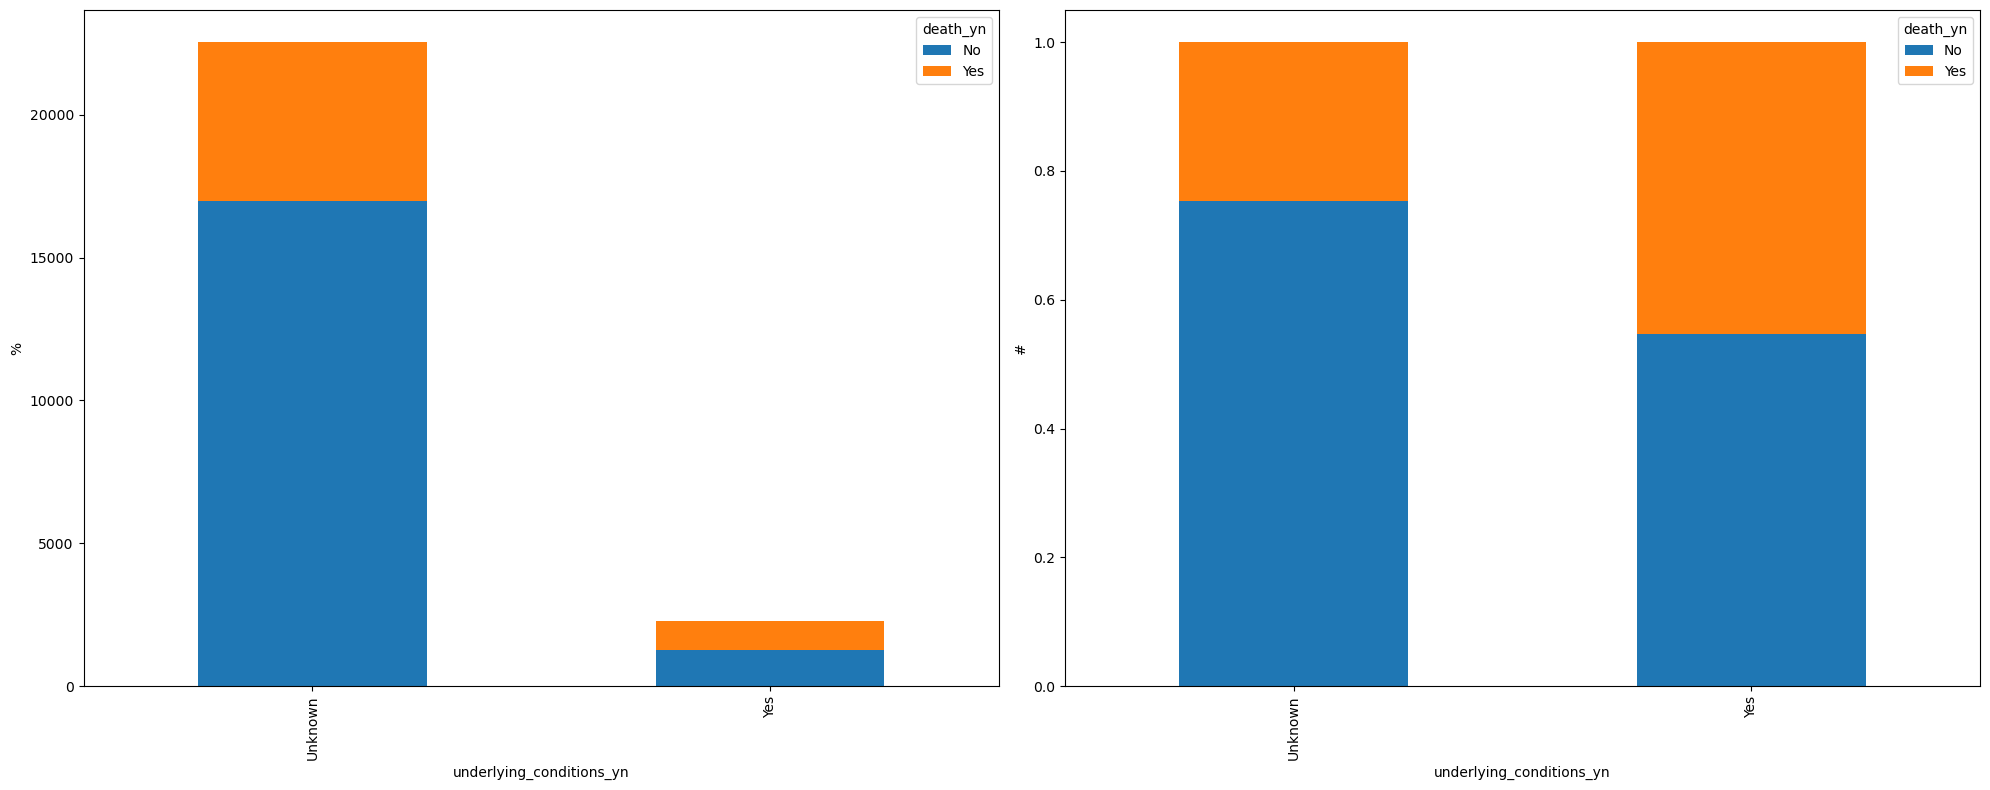

In [958]:
target_feature = train['death_yn']
select_features = [train['case_month'], train['res_state'], train['age_group'], train['hosp_yn'], train['exposure_yn'], train['icu_yn'], train['underlying_conditions_yn']]

for feature in select_features:
  
    fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
    train.groupby([feature, target_feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
    axs[0].set_ylabel('%')

    train.groupby([feature, target_feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
    axs[1].set_ylabel('#')
    
    plt.tight_layout()
    plt.show()

# Sociological Related Categorical Features Plotted Against Death

Here we are looking discern patterns from our dataset by plotting deaths (yes/no) against a number of sociological features: race, ethnicity, sex.

1. The race of the patient.
2. The ethnicity of the patient.
3. The sex of the patient.

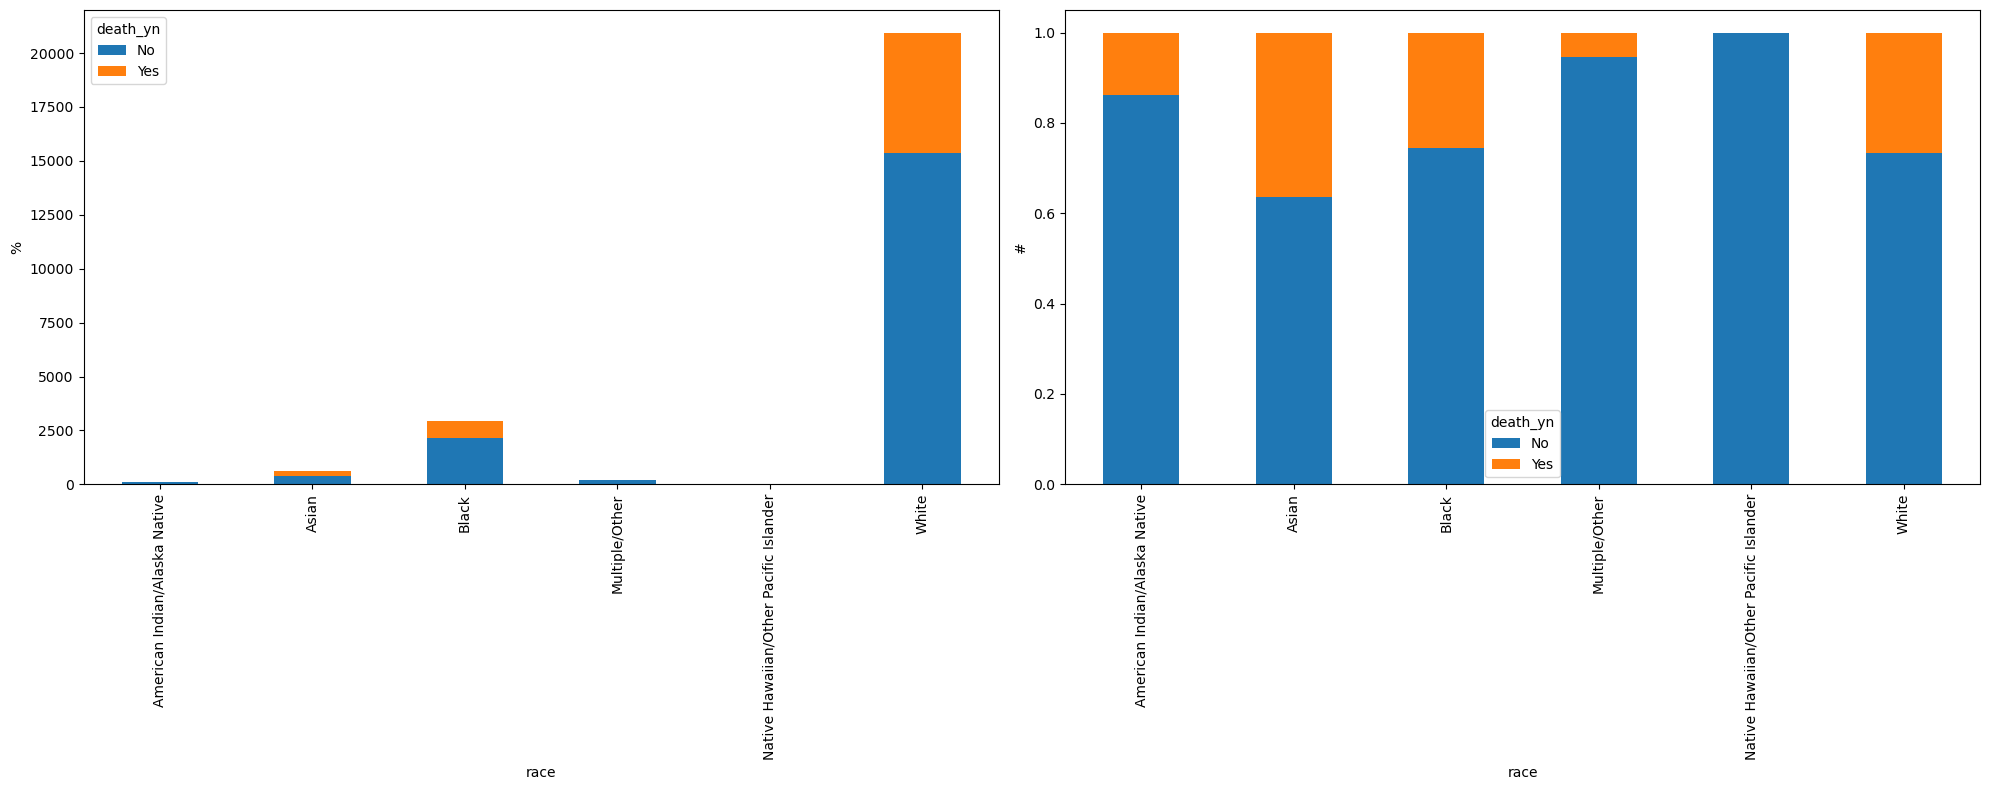

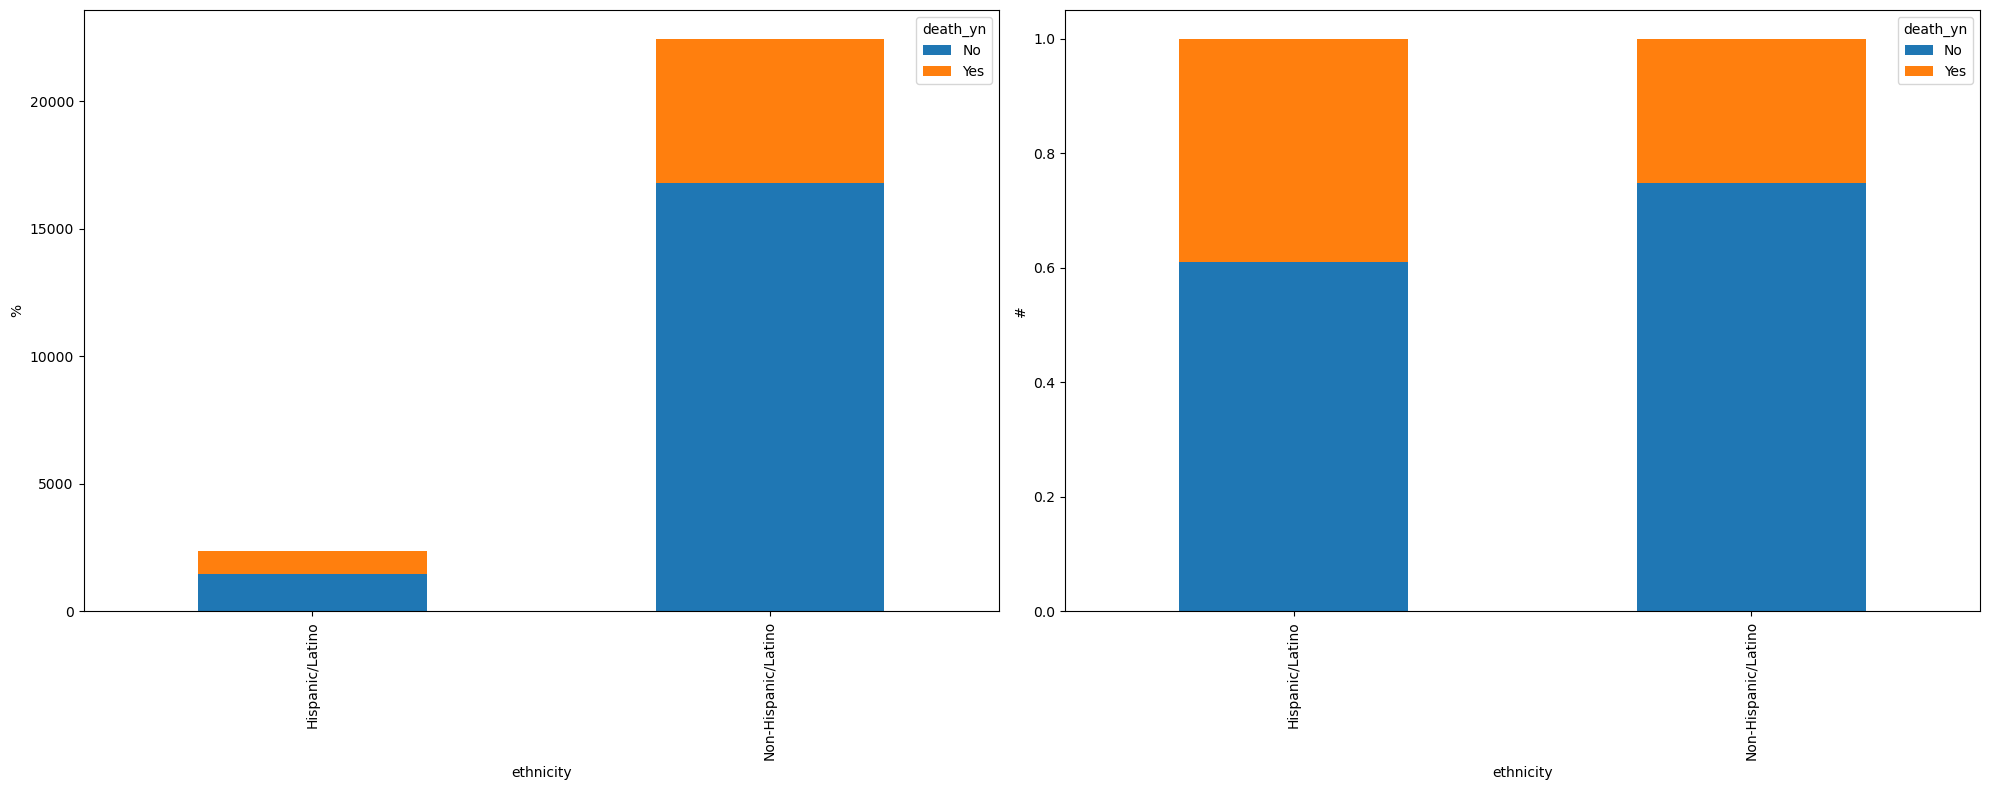

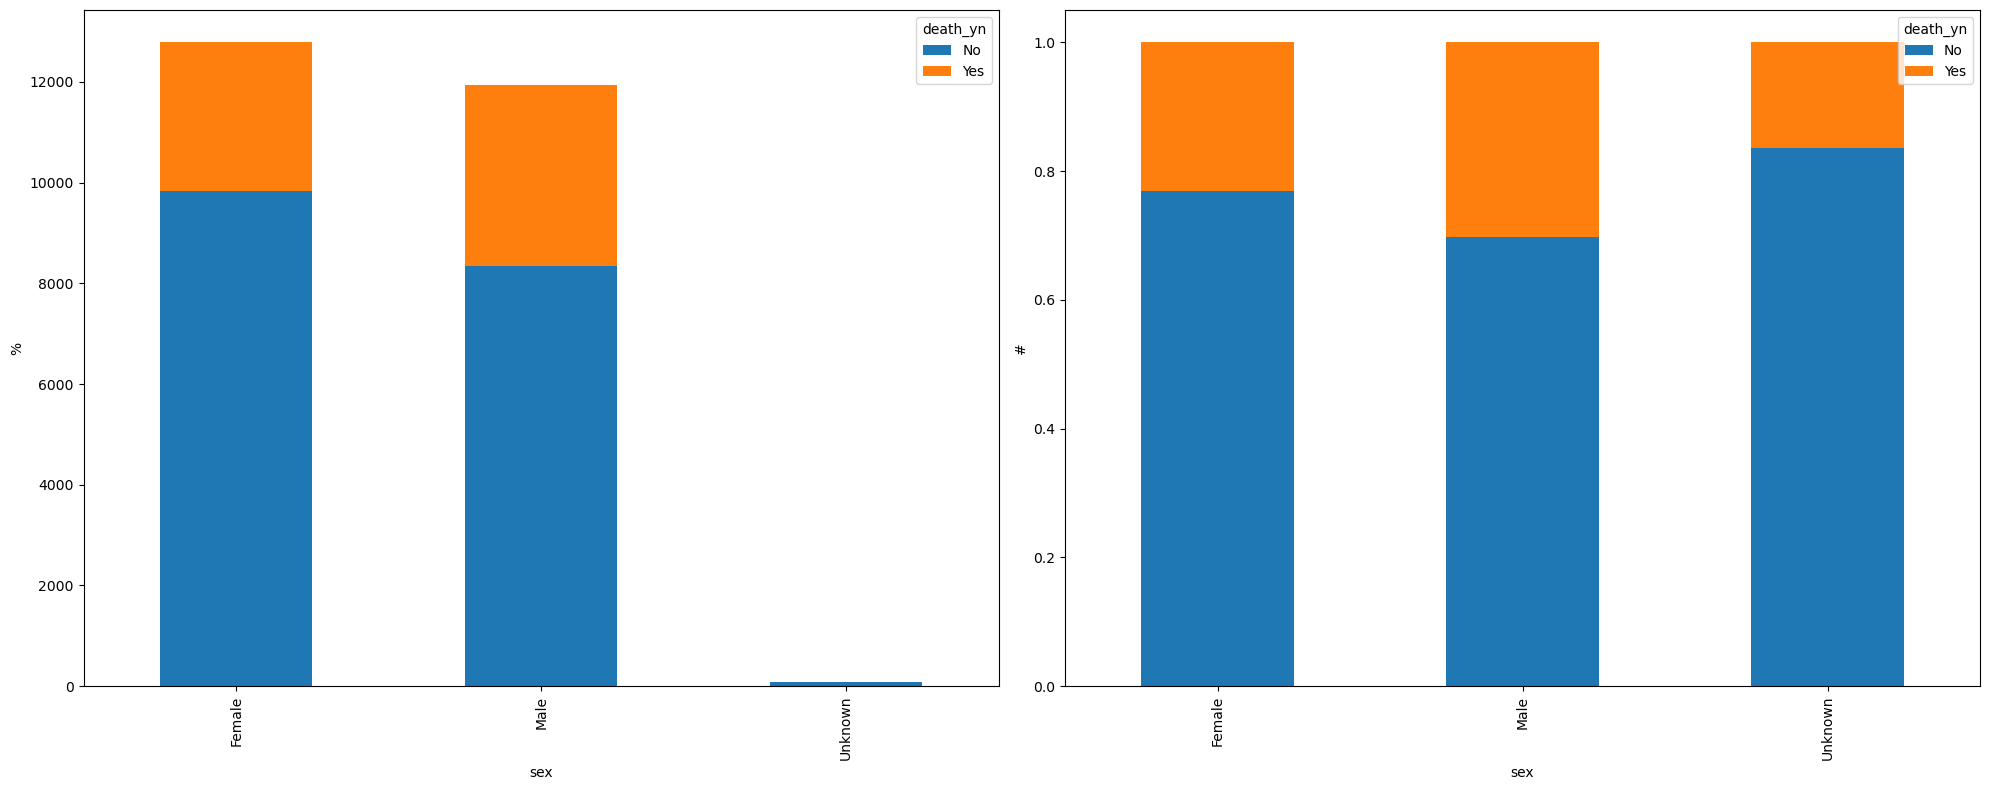

In [959]:

target_features = [train['race'], train['ethnicity'], train['sex']]
select_features = [train['death_yn']]

for target_feature in target_features:

    for feature in select_features:

        fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
        train.groupby([target_feature, feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0])
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
        axs[0].set_ylabel('%')

        train.groupby([target_feature, feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1])
        axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
        axs[1].set_ylabel('#')
        
        plt.tight_layout()
        plt.show()

## Observations/Summary:

1. As the COVID19 pandemic progressed, we can generally observe both a reduction in the number of deaths per month and the proporption of deaths with regards the whole, month-on-month. The outlier here is January 2022. From the CDC dataset provided, we cannot discern whether or not the patient was vaccinated, however we can use the months here as a proxy for the Vaccine rollout program in the US, which began mid-December 2020 and had more or less concluded by the end of the following year. The death ratio falling against total cases broadly follows the vaccination rollout scheme, despite this information not formally recorded in our dataset.

2. The data also suggests that age is a predominant and robust factor when gauging the impact contracting COVID will have on your health. Our data shows that those who belong to the oldest age bracket (65+) and test positive for COVID are far more likely to die than those who are younger (compare 65+ against 0-17 years old). Our data also shows that those who are older are more exposed to the risk of COVID, in that the oldest age bucket leads in terms of hospitalisations, ICU admissions, and underlying conditions in comparison to the other age brackets. This aligns with what is now known about COVID-19, that older adults and those with underlying health conditions are considered to be at a higher risk of severe illness and death from COVID-19. 

3. The data also demonstrates that having underlying medical conditions increases the risk of hospitalisation, ICU admission, and death from COVID-19. And while we do not get access to the comorbidities affecting the patients in our dataset, those who reported as having underlying conditions such as diabtes, hypertension, obesity (etc.), confer a much higher risk of death from COVID-19 than others.

4. The data also shows that in the event of being admitted to hospital or the ICU, the success of making a full recovery is limited, and drasticly decreases the older you are. The data also proves the opposite whereby the younger you are the more resilient you are to COVID, leading to far fewer hospitalisation, admissions to ICU, and deaths. 

5. The data also shows that minorities, categorised in our race and ethnicity features (Black, Hispanic, Asian), are hospitalised, admitted to ICU, and die more regularly than their white counterparts pro rata. Without more granular information on our patient it is hard to say exactly what factors are driving these disparities: access to healthcare; wealth; etc.,

6. The data also demonstrates that there is a weak correlation between case_onset_intervals and case_positive_specimen_intervals, with the correlation coefficient is close to zero. This indicates that the timing of when a person experiences symptoms (case onset interval) and when they test positive for COVID-19 (case positive specimen interval) are not strongly associated with each other.

7. Our data also shows that there is a weak negative correlation between our continuous features, and when we map these continuous features against our target feature, there is no real discernible pattern that differents yes from no.


## Selected Features

Based on the above observations, the subset of features we are going to use to model the health profile of our patients are: 

i. <b>age</b>, 
ii. <b>case month</b>, 
iii. <b>hospilisation status</b>, 
iv. <b>ICU status</b>, 
v. <b>underlying conditions</b>. 


# Task 2: Linear Regression

The aim of this task is to perform some basic predictive analysis on the data prepared in task one. To this end, a linear regression model will be created using the training data yielded by the train-test split from the previous task. The features to be analyzed in this section are:

i. <b>age</b>, 
ii. <b>case month</b>, 
iii. <b>hospilisation status</b>, 
iv. <b>ICU status</b>, 
v. <b>underlying conditions</b>. 

 The model will then be evaluated based on its performance using the training data, the test data, and other linear regression models trained on the full dataset. 

In [960]:
linear_regression_features_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'death_yn']]
linear_regression_features_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'death_yn']]

for f in linear_regression_features_train:
    print(f, linear_regression_features_train[f].dtypes)

case_month object
age_group object
hosp_yn object
icu_yn object
underlying_conditions_yn object
death_yn object


## 2.1

In [961]:
month_map = {'2020-01': 0, 
             '2020-02': 1, 
             '2020-03': 2, 
             '2020-04': 3,
             '2020-05': 4,
             '2020-06': 5,
             '2020-07': 6,
             '2020-08': 7,
             '2020-09': 8,
             '2020-10': 9,
             '2020-11': 10,
             '2020-12': 11,
             '2021-01': 12,
             '2021-02': 13,
             '2021-03': 14,
             '2021-04': 15,
             '2021-05': 16,
             '2021-06': 17,
             '2021-07': 18,
             '2021-08': 19,
             '2021-09': 20,
             '2021-10': 21,
             '2021-11': 22,
             '2021-12': 23,
             '2022-01': 24,
             '2022-02': 25,
             '2022-03': 26,
             '2022-04': 27,
             '2022-05': 28,
             '2022-06': 29,
             '2022-07': 30,
             '2022-08': 31,
             '2022-09': 32,
             '2022-10': 33,
             '2022-11': 34}

train['case_month'] = train['case_month'].map(month_map)
test['case_month'] = test['case_month'].map(month_map)

In [962]:
age_map = {'0 - 17 years': 0, 
           '18 to 49 years': 1, 
           '50 to 64 years': 2, 
           '65+ years': 3
           }

train['age_group'] = train['age_group'].map(age_map)
test['age_group'] = test['age_group'].map(age_map)

In [963]:
hosp_map = { 'Unknown': 0, 
            'Yes': 1, 
            }

train['hosp_yn'] = train['hosp_yn'].map(hosp_map)
test['hosp_yn'] = test['hosp_yn'].map(hosp_map)

In [964]:
icu_map = {'Unknown': 0, 
            'Yes': 1, 
            }

train['icu_yn'] = train['icu_yn'].map(icu_map)
test['icu_yn'] = test['icu_yn'].map(icu_map)

In [965]:
underlying_map = {'Unknown': 0, 
            'Yes': 1, 
            }

train['underlying_conditions_yn'] = train['underlying_conditions_yn'].map(underlying_map)
test['underlying_conditions_yn'] = test['underlying_conditions_yn'].map(underlying_map)

In [966]:
death_map = {'No': 0,
             'Yes': 1,
             }

train['death_yn'] = train['death_yn'].map(death_map)
test['death_yn'] = test['death_yn'].map(death_map)

In [967]:
x_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
y_train = train['death_yn']

x_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
y_test = test['death_yn']

In [968]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("MSE: ", mse)
print("R^2: ", r2)

MSE:  0.08110865665779961
R^2:  0.5835118888564079


## 2.2

In [969]:
for feature, coef in zip(x_train.columns, lr.coef_):
    print(feature, ':', coef)

case_month : -0.006671027476552113
age_group : 0.19863988806863098
hosp_yn : 0.4135647729742
icu_yn : 0.1474146759094816
underlying_conditions_yn : -0.056806768875386895


## 2.3

In [970]:
# predict target feature values for first 10 training examples
y_train_pred = lr.predict(x_train[:10])
print("Predicted target feature values for first 10 training examples:\n", y_train_pred)
print()
# threshold predicted target feature values to get predicted classes
y_train_pred_class = (lr.predict(x_train[:10]) > 0.5).astype(int)
print("Predicted class for first 10 training examples:\n", y_train_pred_class)

Predicted target feature values for first 10 training examples:
 [ 0.20900546  0.85456526 -0.0464412   0.9613017  -0.06152479  0.0904179
  0.48425913 -0.15491918 -0.01975709  0.85456526]

Predicted class for first 10 training examples:
 [0 1 0 1 0 0 0 0 0 1]


In [972]:
# evaluate model on full training set
y_train_pred = lr.predict(x_train)

y_train_pred_class = (y_train_pred > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred_class)
confusion_train = confusion_matrix(y_train, y_train_pred_class)
precision_train = precision_score(y_train, y_train_pred_class)
recall_train = recall_score(y_train, y_train_pred_class)
f1_train = f1_score(y_train, y_train_pred_class)

print("\nEvaluation metrics on the training set:")
print("Accuracy: {:.2f}".format(accuracy_train))
print("Confusion matrix:\n", confusion_train)
print("Precision: {:.2f}".format(precision_train))
print("Recall: {:.2f}".format(recall_train))
print("F1 score: {:.2f}".format(f1_train))


Evaluation metrics on the training set:
Accuracy: 0.89
Confusion matrix:
 [[17437   811]
 [ 1992  4585]]
Precision: 0.85
Recall: 0.70
F1 score: 0.77


In [ ]:
# make predictions on the training set and evaluate the model performance
y_train_pred = lr.predict(x_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("Evaluation metrics on the training set:")
print("Mean Absolute Error: {:.2f}".format(mae_train))
print("Mean Squared Error: {:.2f}".format(mse_train))
print("Root Mean Squared Error: {:.2f}".format(rmse_train))
print("R2 score: {:.2f}".format(r2_train))

# make predictions on the test set and evaluate the model performance
y_test_pred = lr.predict(x_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nEvaluation metrics on the test set:")
print("Mean Absolute Error: {:.2f}".format(mae_test))
print("Mean Squared Error: {:.2f}".format(mse_test))
print("Root Mean Squared Error: {:.2f}".format(rmse_test))
print("R2 score: {:.2f}".format(r2_test))

# Task 4: Random Forest
### Train a random forest model to predict the target feature

Subset of features: ['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']

Target feature: ['death_yn']

In [ ]:
random_forest_features = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'death_yn']]

for f in random_forest_features:
    print(f, random_forest_features[f].dtypes)

In [ ]:
random_forest_features_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'death_yn']]
random_forest_features_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn','death_yn']]

for f in random_forest_features:
    print(f, random_forest_features[f].unique())

In [ ]:
x_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
y_train = train['death_yn']

x_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
y_test = test['death_yn']

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

In [ ]:
y_pred = rfc.predict(x_train)
print(y_pred[:10])

In [ ]:
print(rfc.predict_proba(x_train)[:10])

In [ ]:
y_pred = rfc.predict(x_train)
print("Accuracy: ", accuracy_score(y_train, y_pred))

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

## Table Summary of Algorithm Complexities 

| *Predicted Positive*  | *Predicted Negative* |
|:--------------:|:-------------:|
| (TP) = ~5700    | (FN) = ~ 700    |
| (FP) = ~1100     | (TN) = ~ 17000    |

In [ ]:
print("Classification Report:\n", classification_report(y_train, y_pred))

In [ ]:
print("Precision:", precision_score(y_train, y_pred))

In [ ]:
print("Recall:", recall_score(y_train, y_pred))

In [ ]:
print("F1 Score:", f1_score(y_train, y_pred))

In [ ]:
model = RandomForestRegressor() # create instance of the model
model.fit(x_train, y_train) # fit the model to the training data

y_pred = model.predict(x_test)

#Evaluate the performance of your model:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

score = model.score(x_test, y_test)
print(f"R^2 score on testing data: {score}")